# Judith

Let's start with the first heroine - Judith. In order to explore how she was represented in painting, we will use Wikidata.

In [1]:
!pip install --quiet rdflib SPARQLWrapper pandas

You should consider upgrading via the '/home/aschi/Documents/Judith-and-Salome/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import rdflib
import ssl
import json
import pprint
import pandas as pd
from pprint import pprint
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import URIRef

Judith = URIRef("https://www.wikidata.org/wiki/Q26454627")
depicts_relation = URIRef('https://www.wikidata.org/wiki/Property:P180')
item = URIRef("https://www.wikidata.org/wiki/Property:P1629")
creative_work = URIRef("https://www.wikidata.org/wiki/Q17537576")

ssl._create_default_https_context = ssl._create_unverified_context
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"
sparql_wd = SPARQLWrapper(wikidata_endpoint)
sparql_wd.setReturnFormat(JSON)

Let's retrieve all records where Judith is an object

In [3]:
query = """
    SELECT DISTINCT ?subject ?relation
    WHERE {
        ?subject ?relation wd:Q26454627 .
    }
"""
sparql_wd.setQuery(query)

results = sparql_wd.query().convert()
results = pd.DataFrame([
     {
         'subject': result['subject']['value'],
         'relation': result['relation']['value'],
     }
     for result in results['results']['bindings']
])

len(results)

305

Let's list all (unique) relations and find out whether all of them are informative for us and fit our needs

In [4]:
results['relation'].drop_duplicates().sort_values().reset_index(drop=True)

0                          http://schema.org/about
1             http://www.w3.org/2002/07/owl#sameAs
2         http://www.wikidata.org/prop/direct/P138
3         http://www.wikidata.org/prop/direct/P157
4         http://www.wikidata.org/prop/direct/P180
5        http://www.wikidata.org/prop/direct/P1889
6          http://www.wikidata.org/prop/direct/P26
7         http://www.wikidata.org/prop/direct/P301
8         http://www.wikidata.org/prop/direct/P460
9         http://www.wikidata.org/prop/direct/P674
10        http://www.wikidata.org/prop/direct/P735
11        http://www.wikidata.org/prop/direct/P921
12        http://www.wikidata.org/prop/direct/P971
13     http://www.wikidata.org/prop/statement/P138
14     http://www.wikidata.org/prop/statement/P157
15     http://www.wikidata.org/prop/statement/P180
16    http://www.wikidata.org/prop/statement/P1889
17      http://www.wikidata.org/prop/statement/P26
18     http://www.wikidata.org/prop/statement/P301
19     http://www.wikidata.org/

We see we have two versions (with 'direct' and 'statement' inside) of each relation, and both links redirect to the same page https://www.wikidata.org/wiki/Property:P[\d{3-4}].

We filter out following relations:

* http://schema.org/about: because it's just an information about the biblical character in different languages, not the art works.
* http://www.wikidata.org/prop/direct/P921 and http://www.wikidata.org/prop/statement/P921: because it's primary topic of a work, but not necessarily pictures
* http://www.wikidata.org/prop/direct/P1889 and http://www.wikidata.org/prop/statement/P1889: because it's about item that is different from another item. This is not necessarily about paintings, so we must remove it.
* http://www.wikidata.org/prop/direct/P674 and http://www.wikidata.org/prop/statement/P674: because it means characters which appear in this item (like plays, operas, operettas, books, comics, films, TV series, video games). We only consider paintings, so we don't need them.
* http://www.wikidata.org/prop/direct/P157 and http://www.wikidata.org/prop/statement/P157: because it's 'killed by'. We don't need it.
* http://www.wikidata.org/prop/direct/P301 and http://www.wikidata.org/prop/statement/P301: because it's a 'category'.
* http://www.wikidata.org/prop/direct/P971 and http://www.wikidata.org/prop/statement/P971: because it's'category combines topics', it's not about painting.
* http://www.wikidata.org/prop/direct/P26 and http://www.wikidata.org/prop/statement/P26: because it's 'spouse'. This is also not about art works.

Hence the only relation that we are interested in is 'depicts' (http://www.wikidata.org/prop/direct/P180 + http://www.wikidata.org/prop/statement/P180):

In [5]:
mask = results['relation'].isin([
  'http://www.wikidata.org/prop/direct/P180',
  'http://www.wikidata.org/prop/statement/P180',
])

results = results[mask].reset_index(drop=True)

len(results)

248


Let's inspect the subjects:

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    print(results['subject'].drop_duplicates())

0                                                     http://www.wikidata.org/entity/Q107723883
1                                                     http://www.wikidata.org/entity/Q110846785
2                                                     http://www.wikidata.org/entity/Q113282497
3                                                      http://www.wikidata.org/entity/Q17583741
4                                                      http://www.wikidata.org/entity/Q18592435
5                                                      http://www.wikidata.org/entity/Q18602193
6                                                      http://www.wikidata.org/entity/Q18749410
7                                                      http://www.wikidata.org/entity/Q18749466
8                                                      http://www.wikidata.org/entity/Q18749470
9                                                      http://www.wikidata.org/entity/Q19404584
10                                      

We notice some unusual links which are called statements in wikidata. The statement links allow to jump immediately to the statement label that is indicated, but we don't need them because these are links to the pages with pictures we already have. We should exclude them.

In [7]:
mask = ~results['subject'].str.contains('statement')
results = results[mask].reset_index(drop=True)

len(results)

124

Now we notice that only one variant (with 'direct' inside) of 'depicts' relation is left in our dataset.

In [8]:
results['relation'].unique()

array(['http://www.wikidata.org/prop/direct/P180'], dtype=object)

So, we could actually use this particular relation to obtain the same set of artworks:
```
WHERE {
    ?subject wdt:P180 wd:Q28532552 .
}
```


We also notice that we have а group of paintings by and after Cristofano Allori (http://www.wikidata.org/entity/Q43150796). It consists of six works. Five of them were in results of our query, but one (https://www.wikidata.org/wiki/Q27978379) was not. We should delete the link to the group of paintings and will later add the link to the painting not included in the dataset.

In order to find out in which cultures the plot is most popular, we need more infomration. We will gather more information from wikidata about the paintings and also look at the authors of the paintings.

# JUDITH ARTWORKS

In [9]:
query = """
      SELECT ?uri ?name ?image_uri
             (YEAR(?inception_date) AS ?inception_year) ?inception_precision
             (YEAR(?earliest_date) AS ?earliest_year) (YEAR(?latest_date) AS ?latest_year)
             ?location_uri ?collection_uri ?collection_name ?creator_uri
      WHERE {
          ?uri wdt:P31 wd:Q3305213 .
          ?uri wdt:P180 wd:Q26454627 .
          OPTIONAL { ?uri wdt:P18 ?image_uri . }
          OPTIONAL { ?uri p:P571/pq:P1319 ?earliest_date . }
          OPTIONAL { ?uri p:P571/pq:P1326 ?latest_date . }
          OPTIONAL {
              ?uri p:P571/psv:P571 [
                  wikibase:timeValue ?inception_date ;
                  wikibase:timePrecision ?inception_precision ;
              ]
          }
          OPTIONAL { ?uri wdt:P276 ?location_uri . }
          OPTIONAL { ?uri wdt:P195 ?collection_uri . }
          OPTIONAL { ?uri wdt:P170 ?creator_uri . }
          SERVICE wikibase:label {
            bd:serviceParam wikibase:language "en,de" .
            ?uri rdfs:label ?name .
            ?collection_uri rdfs:label ?collection_name .
          }
      }
 """

sparql_wd.setQuery(query)
artworks_response = sparql_wd.query().convert()

keys = [
    'uri', 'name', 'image_uri', 'inception_year', 'inception_precision',
    'earliest_year', 'latest_year', 'location_uri', 'collection_uri',
    'collection_name', 'creator_uri'
]
artworks_response = [
    {key: result.get(key, {}).get('value', None) for key in keys}
    for result in artworks_response['results']['bindings']
]

pprint(artworks_response[0])
pprint(artworks_response[1])
len(artworks_response)

{'collection_name': 'Statens Museum for Kunst',
 'collection_uri': 'http://www.wikidata.org/entity/Q671384',
 'creator_uri': 'http://www.wikidata.org/entity/Q544264',
 'earliest_year': None,
 'image_uri': 'http://commons.wikimedia.org/wiki/Special:FilePath/Denys%20Calvaert%20-%20Judith%20with%20the%20Head%20of%20Holofernes%20-%20KMS981%20-%20Statens%20Museum%20for%20Kunst.jpg',
 'inception_precision': None,
 'inception_year': None,
 'latest_year': None,
 'location_uri': 'http://www.wikidata.org/entity/Q671384',
 'name': 'Judith with the Head of Holofernes',
 'uri': 'http://www.wikidata.org/entity/Q20277944'}
{'collection_name': 'Museum of Fine Arts Boston',
 'collection_uri': 'http://www.wikidata.org/entity/Q49133',
 'creator_uri': 'http://www.wikidata.org/entity/Q982384',
 'earliest_year': None,
 'image_uri': 'http://commons.wikimedia.org/wiki/Special:FilePath/Massimo%20Stanzione%20-%20Judith%20with%20the%20Head%20of%20Holofernes%20-%2094.181%20-%20Museum%20of%20Fine%20Arts.jpg',
 'in

163

# JUDITH CREATORS

In [10]:
creator_uris = set()

for painting in artworks_response:
  if painting['creator_uri'] and 'well-known' not in painting['creator_uri']:
    creator_uris.add(painting['creator_uri'])


creator_uris = [f"wd:{uri[uri.rindex('/') + 1:]}" for uri in creator_uris]

print(creator_uris[0])
print(creator_uris[1])
len(creator_uris)

wd:Q951884
wd:Q763585


81

In [11]:
query = """
    SELECT ?uri ?name ?gender ?citizenship
        (YEAR(?birth_date) AS ?birth_year) (YEAR(?death_date) AS ?death_year)
        ?birth_place_uri ?death_place_uri ?work_location_uri
    WHERE {
        VALUES ?uri {""" +  ' '.join(creator_uris)  + """}
        OPTIONAL { ?uri wdt:P21 ?gender_uri . }
        OPTIONAL { ?uri wdt:P27 ?citizenship . }
        OPTIONAL { ?uri wdt:P569 ?birth_date . }
        OPTIONAL { ?uri wdt:P570 ?death_date . }
        OPTIONAL { ?uri wdt:P19 ?birth_place_uri . }
        OPTIONAL { ?uri wdt:P20 ?death_place_uri . }
        OPTIONAL { ?uri wdt:P937 ?work_location_uri . }
        SERVICE wikibase:label {
            bd:serviceParam wikibase:language "en,de" .
            ?uri rdfs:label ?name .
            ?gender_uri rdfs:label ?gender .
        }
    }
 """

sparql_wd.setQuery(query)
creators_response = sparql_wd.query().convert()

keys = [
    'uri', 'name', 'gender', 'citizenship', 'birth_year', 'death_year',
    'birth_place_uri', 'death_place_uri', 'work_location_uri'
]
creators_response = [
    {key: result.get(key, {}).get('value', None) for key in keys}
    for result in creators_response['results']['bindings']
]

pprint(creators_response[0])
pprint(creators_response[1])
len(creators_response)

{'birth_place_uri': 'http://www.wikidata.org/entity/Q1372769',
 'birth_year': '1746',
 'citizenship': 'http://www.wikidata.org/entity/Q29',
 'death_place_uri': 'http://www.wikidata.org/entity/Q1479',
 'death_year': '1828',
 'gender': 'male',
 'name': 'Francisco de Goya',
 'uri': 'http://www.wikidata.org/entity/Q5432',
 'work_location_uri': 'http://www.wikidata.org/entity/Q29'}
{'birth_place_uri': 'http://www.wikidata.org/entity/Q1372769',
 'birth_year': '1746',
 'citizenship': 'http://www.wikidata.org/entity/Q29',
 'death_place_uri': 'http://www.wikidata.org/entity/Q1479',
 'death_year': '1828',
 'gender': 'male',
 'name': 'Francisco de Goya',
 'uri': 'http://www.wikidata.org/entity/Q5432',
 'work_location_uri': 'http://www.wikidata.org/entity/Q38'}


348

# JUDITH LOCATIONS

In [12]:
location_uris = set()

for creator in creators_response:
    if creator['birth_place_uri']:
        location_uris.add(creator['birth_place_uri'])
    if creator['death_place_uri']:
        location_uris.add(creator['death_place_uri'])
    if creator['work_location_uri']:
        location_uris.add(creator['work_location_uri'])

for artwork in artworks_response:
    if artwork['location_uri']:
        location_uris.add(artwork['location_uri'])

location_uris = [f"wd:{uri[uri.rindex('/') + 1:]}" for uri in location_uris]

print(location_uris[0])
print(location_uris[1])
len(location_uris)

wd:Q2720391
wd:Q490


193

In [13]:
query = """
    SELECT ?uri ?name ?lat ?lon ?country_name
    WHERE {
        VALUES ?uri {""" +  ' '.join(location_uris)  + """}
        ?uri p:P625/psv:P625 [ wikibase:geoLatitude ?lat ; wikibase:geoLongitude ?lon ; ] .
        ?uri wdt:P17 ?country
        SERVICE wikibase:label {
            bd:serviceParam wikibase:language "en,de" .
            ?uri rdfs:label ?name .
            ?country rdfs:label ?country_name
        }
    }
 """

sparql_wd.setQuery(query)
locations_response = sparql_wd.query().convert()

keys = ['uri', 'name', 'lat', 'lon', 'country_name']
locations_response = [
    {key: result.get(key, {}).get('value', None) for key in keys}
    for result in locations_response['results']['bindings']
]

pprint(locations_response[0])
pprint(locations_response[1])
len(locations_response)

{'country_name': 'Spain',
 'lat': '40.2',
 'lon': '-3.5',
 'name': 'Spain',
 'uri': 'http://www.wikidata.org/entity/Q29'}
{'country_name': 'Italy',
 'lat': '44.407186111111',
 'lon': '8.9339833333333',
 'name': 'Genoa',
 'uri': 'http://www.wikidata.org/entity/Q1449'}


218

Create dicts from lists

In [14]:
artworks_by_uri = {item['uri']: item for item in artworks_response}
creators_by_uri = {item['uri']: item for item in creators_response}
locations_by_uri = {item['uri']: item for item in locations_response}

print(artworks_by_uri.keys())
print(creators_by_uri.keys())
print(locations_by_uri.keys())

dict_keys(['http://www.wikidata.org/entity/Q20277944', 'http://www.wikidata.org/entity/Q20549802', 'http://www.wikidata.org/entity/Q28001898', 'http://www.wikidata.org/entity/Q28002900', 'http://www.wikidata.org/entity/Q29909510', 'http://www.wikidata.org/entity/Q30057872', 'http://www.wikidata.org/entity/Q30097339', 'http://www.wikidata.org/entity/Q29938854', 'http://www.wikidata.org/entity/Q30096134', 'http://www.wikidata.org/entity/Q28778013', 'http://www.wikidata.org/entity/Q20891049', 'http://www.wikidata.org/entity/Q27981523', 'http://www.wikidata.org/entity/Q52207936', 'http://www.wikidata.org/entity/Q107650490', 'http://www.wikidata.org/entity/Q29479966', 'http://www.wikidata.org/entity/Q29919256', 'http://www.wikidata.org/entity/Q29938834', 'http://www.wikidata.org/entity/Q29938841', 'http://www.wikidata.org/entity/Q30098509', 'http://www.wikidata.org/entity/Q28071787', 'http://www.wikidata.org/entity/Q644887', 'http://www.wikidata.org/entity/Q17334315', 'http://www.wikidata.o

Join data

In [15]:
artworks = list(artworks_by_uri.values()) # transform back to list
artworks = [obj.copy() for obj in artworks] # need to create copies because we will modify the objects

for artwork in artworks:
    artwork_creator = creators_by_uri.get(artwork['creator_uri'], {})
    for key in ['name', 'gender', 'citizenship']:
        artwork[f'creator_{key}'] = artwork_creator.get(key, None)

    artwork_location = locations_by_uri.get(artwork['location_uri'], {})
    for key in ['name', 'lat', 'lon', 'country_name']:
        artwork[f'location_{key}'] = artwork_location.get(key, None)

pd.DataFrame(artworks)

,uri,name,image_uri,inception_year,inception_precision,earliest_year,latest_year,location_uri,collection_uri,collection_name,creator_uri,creator_name,creator_gender,creator_citizenship,location_name,location_lat,location_lon,location_country_name
0,http://www.wikidata.org/entity/Q20277944,Judith with the Head of Holofernes,http://commons.wikimedia.org/wiki/Special:File...,None,None,None,None,http://www.wikidata.org/entity/Q671384,http://www.wikidata.org/entity/Q671384,Statens Museum for Kunst,http://www.wikidata.org/entity/Q544264,Denys Calvaert,male,http://www.wikidata.org/entity/Q6581823,Statens Museum for Kunst,55.68889,12.57861,Denmark
1,http://www.wikidata.org/entity/Q20549802,Judith with the Head of Holofernes,http://commons.wikimedia.org/wiki/Special:File...,None,None,None,None,http://www.wikidata.org/entity/Q49133,http://www.wikidata.org/entity/Q49133,Museum of Fine Arts Boston,http://www.wikidata.org/entity/Q982384,Massimo Stanzione,male,http://www.wikidata.org/entity/Q173065,Museum of Fine Arts Boston,42.339166666667,-71.094166666667,United States of America
2,http://www.wikidata.org/entity/Q28001898,Judith,http://commons.wikimedia.org/wiki/Special:File...,None,None,None,None,http://www.wikidata.org/entity/Q303139,http://www.wikidata.org/entity/Q303139,Belvedere,http://www.wikidata.org/entity/Q28813418,Leopold Pollak,male,http://www.wikidata.org/entity/Q131964,Belvedere,48.19139,16.38049,Austria
3,http://www.wikidata.org/entity/Q28002900,Judith mit dem Haupt des Holofernes,http://commons.wikimedia.org/wiki/Special:File...,None,None,None,None,http://www.wikidata.org/entity/Q303139,http://www.wikidata.org/entity/Q303139,Belvedere,http://www.wikidata.org/entity/Q28055102,Joseph Hasslwander,male,http://www.wikidata.org/entity/Q28513,Belvedere,48.19139,16.38049,Austria
4,http://www.wikidata.org/entity/Q29909510,Geschichte der Judith (Kopie nach),http://commons.wikimedia.org/wiki/Special:File...,None,None,None,None,http://www.wikidata.org/entity/Q812285,http://www.wikidata.org/entity/Q812285,Bavarian State Painting Collections,http://www.wikidata.org/entity/Q675272,Hans Leonhard Schäufelein,male,http://www.wikidata.org/entity/Q183,Bavarian State Painting Collections,48.149583,11.571776,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,http://www.wikidata.org/entity/Q26772504,Judith with the head of Holofernes,http://commons.wikimedia.org/wiki/Special:File...,1630,8,None,None,http://www.wikidata.org/entity/Q95569,http://www.wikidata.org/entity/Q95569,Kunsthistorisches Museum,http://www.wikidata.org/entity/Q1727824,Alessandro Varotari,male,http://www.wikidata.org/entity/Q4948,Kunsthistorisches Museum,48.203802,16.361787,Austria
110,http://www.wikidata.org/entity/Q27698577,Judith and Holofernes,http://commons.wikimedia.org/wiki/Special:File...,1577,9,None,None,http://www.wikidata.org/entity/Q171517,http://www.wikidata.org/entity/Q160112,Museo del Prado,http://www.wikidata.org/entity/Q9319,Jacopo Tintoretto,male,http://www.wikidata.org/entity/Q4948,Royal Palace of Madrid,40.417955,-3.714312,Spain
111,http://www.wikidata.org/entity/Q27700979,Judith offering the Head of Holofernes,http://commons.wikimedia.org/wiki/Special:File...,1636,9,None,None,http://www.wikidata.org/entity/Q160112,http://www.wikidata.org/entity/Q160112,Museo del Prado,http://www.wikidata.org/entity/Q541736,Salomon de Bray,male,http://www.wikidata.org/entity/Q170072,Museo del Prado,40.413888888889,-3.6922222222222,Spain
112,http://www.wikidata.org/entity/Q27954769,Judith,http://commons.wikimedia.org/wiki/Special:File...,1650,7,1640,1650,http://www.wikidata.org/entity/Q1848918,http://www.wikidata.org/entity/Q1848918,National Museum of Fine Arts,http://www.wikidata.org/entity/Q951884,Gerard Seghers,male,http://www.wikidata.org/entity/Q6581823,National Museum of Fine Arts,-34.583986,-58.39297,Argentina


In [16]:
pd.DataFrame(artworks).to_excel('./judith.xlsx')

# SALOME

Now let's move on to another heroine - Salome. We'll do the same thing we did for Judith.

In [17]:
query = """
    SELECT DISTINCT ?subject ?relation
    WHERE {
        ?subject ?relation wd:Q228896 .
    }
"""
sparql_wd.setQuery(query)

results = sparql_wd.query().convert()
results = pd.DataFrame([
     {
         'subject': result['subject']['value'],
         'relation': result['relation']['value'],
     }
     for result in results['results']['bindings']
])

len(results)

572

In [18]:
results['relation'].drop_duplicates().sort_values().reset_index(drop=True)

0                          http://schema.org/about
1         http://www.wikidata.org/prop/direct/P138
2         http://www.wikidata.org/prop/direct/P180
3        http://www.wikidata.org/prop/direct/P1889
4          http://www.wikidata.org/prop/direct/P25
5          http://www.wikidata.org/prop/direct/P26
6         http://www.wikidata.org/prop/direct/P301
7        http://www.wikidata.org/prop/direct/P3342
8          http://www.wikidata.org/prop/direct/P40
9         http://www.wikidata.org/prop/direct/P674
10        http://www.wikidata.org/prop/direct/P921
11     http://www.wikidata.org/prop/qualifier/P453
12    http://www.wikidata.org/prop/reference/P3452
13     http://www.wikidata.org/prop/statement/P138
14     http://www.wikidata.org/prop/statement/P180
15    http://www.wikidata.org/prop/statement/P1889
16      http://www.wikidata.org/prop/statement/P25
17      http://www.wikidata.org/prop/statement/P26
18     http://www.wikidata.org/prop/statement/P301
19    http://www.wikidata.org/p

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    print(results['subject'].drop_duplicates())

0                                                                                                            http://www.wikidata.org/entity/Q20054388
1                                                                                                            http://www.wikidata.org/entity/Q20054387
3                                                                                                            http://www.wikidata.org/entity/Q20054389
4                                                                                                            http://www.wikidata.org/entity/Q20054443
5                                                                                                            http://www.wikidata.org/entity/Q20054445
6                                                                                                            http://www.wikidata.org/entity/Q20167006
7                                                                                                   

In [20]:
query = """
      SELECT ?uri ?name ?image_uri
             (YEAR(?inception_date) AS ?inception_year) ?inception_precision
             (YEAR(?earliest_date) AS ?earliest_year) (YEAR(?latest_date) AS ?latest_year)
             ?location_uri ?collection_uri ?collection_name ?creator_uri
      WHERE {
          ?uri wdt:P31 wd:Q3305213 .
          ?uri wdt:P180 wd:Q228896 .
          OPTIONAL { ?uri wdt:P18 ?image_uri . }
          OPTIONAL { ?uri p:P571/pq:P1319 ?earliest_date . }
          OPTIONAL { ?uri p:P571/pq:P1326 ?latest_date . }
          OPTIONAL {
              ?uri p:P571/psv:P571 [
                  wikibase:timeValue ?inception_date ;
                  wikibase:timePrecision ?inception_precision ;
              ]
          }
          OPTIONAL { ?uri wdt:P276 ?location_uri . }
          OPTIONAL { ?uri wdt:P195 ?collection_uri . }
          OPTIONAL { ?uri wdt:P170 ?creator_uri . }
          SERVICE wikibase:label {
            bd:serviceParam wikibase:language "en,de" .
            ?uri rdfs:label ?name .
            ?collection_uri rdfs:label ?collection_name .
          }
      }
 """

sparql_wd.setQuery(query)
artworks_response = sparql_wd.query().convert()

keys = [
    'uri', 'name', 'image_uri', 'inception_year', 'inception_precision',
    'earliest_year', 'latest_year', 'location_uri', 'collection_uri',
    'collection_name', 'creator_uri'
]
artworks_response = [
    {key: result.get(key, {}).get('value', None) for key in keys}
    for result in artworks_response['results']['bindings']
]

pprint(artworks_response[0])
pprint(artworks_response[1])
len(artworks_response)

{'collection_name': 'National Museum of Ancient Art',
 'collection_uri': 'http://www.wikidata.org/entity/Q212459',
 'creator_uri': 'http://www.wikidata.org/entity/Q191748',
 'earliest_year': '1510',
 'image_uri': 'http://commons.wikimedia.org/wiki/Special:FilePath/Salome%20by%20Lucas%20Cranach%20the%20Elder%20-%201st%20third%20of%2016th%20century%20-%20oil%20on%20oak.jpg',
 'inception_precision': '8',
 'inception_year': '1515',
 'latest_year': '1515',
 'location_uri': 'http://www.wikidata.org/entity/Q212459',
 'name': 'Salome with the head of Saint John the Baptist',
 'uri': 'http://www.wikidata.org/entity/Q30005234'}
{'collection_name': 'Gemäldegalerie',
 'collection_uri': 'http://www.wikidata.org/entity/Q165631',
 'creator_uri': 'http://www.wikidata.org/entity/Q598649',
 'earliest_year': '1470',
 'image_uri': None,
 'inception_precision': '6',
 'inception_year': '1490',
 'latest_year': '1510',
 'location_uri': 'http://www.wikidata.org/entity/Q165631',
 'name': 'Salome bringt Herodes 

219

# SALOME CREATORS

In [21]:
creator_uris = set()

for painting in artworks_response:
  if painting['creator_uri'] and 'well-known' not in painting['creator_uri']:
    creator_uris.add(painting['creator_uri'])


creator_uris = [f"wd:{uri[uri.rindex('/') + 1:]}" for uri in creator_uris]

len(creator_uris)

87

In [22]:
query = """
    SELECT ?uri ?name ?gender ?citizenship
        (YEAR(?birth_date) AS ?birth_year) (YEAR(?death_date) AS ?death_year)
        ?birth_place_uri ?death_place_uri ?work_location_uri
    WHERE {
        VALUES ?uri {""" +  ' '.join(creator_uris)  + """}
        OPTIONAL { ?uri wdt:P21 ?gender_uri . }
        OPTIONAL { ?uri wdt:P27 ?citizenship . }
        OPTIONAL { ?uri wdt:P569 ?birth_date . }
        OPTIONAL { ?uri wdt:P570 ?death_date . }
        OPTIONAL { ?uri wdt:P19 ?birth_place_uri . }
        OPTIONAL { ?uri wdt:P20 ?death_place_uri . }
        OPTIONAL { ?uri wdt:P937 ?work_location_uri . }
        SERVICE wikibase:label {
            bd:serviceParam wikibase:language "en,de" .
            ?uri rdfs:label ?name .
            ?gender_uri rdfs:label ?gender .
        }
    }
 """

sparql_wd.setQuery(query)
creators_response = sparql_wd.query().convert()

keys = [
    'uri', 'name', 'gender', 'citizenship', 'birth_year', 'death_year',
    'birth_place_uri', 'death_place_uri', 'work_location_uri'
]
creators_response = [
    {key: result.get(key, {}).get('value', None) for key in keys}
    for result in creators_response['results']['bindings']
]

pprint(creators_response[0])
pprint(creators_response[1])
len(creators_response)

{'birth_place_uri': 'http://www.wikidata.org/entity/Q2044',
 'birth_year': '1486',
 'citizenship': 'http://www.wikidata.org/entity/Q148540',
 'death_place_uri': 'http://www.wikidata.org/entity/Q2044',
 'death_year': '1530',
 'gender': 'male',
 'name': 'Andrea del Sarto',
 'uri': 'http://www.wikidata.org/entity/Q5571',
 'work_location_uri': 'http://www.wikidata.org/entity/Q2044'}
{'birth_place_uri': 'http://www.wikidata.org/entity/Q3167',
 'birth_year': '1577',
 'citizenship': 'http://www.wikidata.org/entity/Q622783',
 'death_place_uri': 'http://www.wikidata.org/entity/Q12892',
 'death_year': '1640',
 'gender': 'male',
 'name': 'Peter Paul Rubens',
 'uri': 'http://www.wikidata.org/entity/Q5599',
 'work_location_uri': 'http://www.wikidata.org/entity/Q84'}


262

# SALOME LOCATIONS

In [23]:
location_uris = set()

for creator in creators_response:
    if creator['birth_place_uri']:
        location_uris.add(creator['birth_place_uri'])
    if creator['death_place_uri']:
        location_uris.add(creator['death_place_uri'])
    if creator['work_location_uri']:
        location_uris.add(creator['work_location_uri'])

for artwork in artworks_response:
    if artwork['location_uri']:
        location_uris.add(artwork['location_uri'])

location_uris = [f"wd:{uri[uri.rindex('/') + 1:]}" for uri in location_uris]

print(location_uris[0])
print(location_uris[1])
len(location_uris)

wd:Q163795
wd:Q490


246

In [24]:
query = """
    SELECT ?uri ?name ?lat ?lon ?country_name
    WHERE {
        VALUES ?uri {""" +  ' '.join(location_uris)  + """}
        ?uri p:P625/psv:P625 [ wikibase:geoLatitude ?lat ; wikibase:geoLongitude ?lon ; ] .
        ?uri wdt:P17 ?country
        SERVICE wikibase:label {
            bd:serviceParam wikibase:language "en,de" .
            ?uri rdfs:label ?name .
            ?country rdfs:label ?country_name
        }
    }
 """

sparql_wd.setQuery(query)
locations_response = sparql_wd.query().convert()

keys = ['uri', 'name', 'lat', 'lon', 'country_name']
locations_response = [
    {key: result.get(key, {}).get('value', None) for key in keys}
    for result in locations_response['results']['bindings']
]

pprint(locations_response[0])
pprint(locations_response[1])
len(locations_response)

{'country_name': 'Italy',
 'lat': '44.407186111111',
 'lon': '8.9339833333333',
 'name': 'Genoa',
 'uri': 'http://www.wikidata.org/entity/Q1449'}
{'country_name': 'Belgium',
 'lat': '50.846666666667',
 'lon': '4.3516666666667',
 'name': 'Brussels',
 'uri': 'http://www.wikidata.org/entity/Q239'}


267

In [25]:
Salome_artworks_by_uri = {item['uri']: item for item in artworks_response}
Salome_creators_by_uri = {item['uri']: item for item in creators_response}
Salome_locations_by_uri = {item['uri']: item for item in locations_response}


In [26]:
Salome_artworks = list(Salome_artworks_by_uri.values()) # transform back to list
Salome_artworks = [obj.copy() for obj in Salome_artworks] # need to create copies because we will modify the objects

for artwork in Salome_artworks:
    Salome_artwork_creator = Salome_creators_by_uri.get(artwork['creator_uri'], {})
    for key in ['name', 'gender', 'citizenship']:
        artwork[f'creator_{key}'] = Salome_artwork_creator.get(key, None)

    Salome_artwork_location = Salome_locations_by_uri.get(artwork['location_uri'], {})
    for key in ['name', 'lat', 'lon', 'country_name']:
        artwork[f'location_{key}'] = Salome_artwork_location.get(key, None)

pd.DataFrame(Salome_artworks)

,uri,name,image_uri,inception_year,inception_precision,earliest_year,latest_year,location_uri,collection_uri,collection_name,creator_uri,creator_name,creator_gender,creator_citizenship,location_name,location_lat,location_lon,location_country_name
0,http://www.wikidata.org/entity/Q30005234,Salome with the head of Saint John the Baptist,http://commons.wikimedia.org/wiki/Special:File...,1515,8,1510,1515,http://www.wikidata.org/entity/Q212459,http://www.wikidata.org/entity/Q212459,National Museum of Ancient Art,http://www.wikidata.org/entity/Q191748,Lucas Cranach the Elder,male,http://www.wikidata.org/entity/Q12548,National Museum of Ancient Art,38.7053,-9.16072,Portugal
1,http://www.wikidata.org/entity/Q107447073,Salome bringt Herodes das Haupt des Johannes,None,1490,6,1470,1510,http://www.wikidata.org/entity/Q165631,http://www.wikidata.org/entity/Q165631,Gemäldegalerie,http://www.wikidata.org/entity/Q598649,Antoniazzo Romano,male,None,Gemäldegalerie,52.50861,13.36472,Germany
2,http://www.wikidata.org/entity/Q30005237,Salome with the Head of St John the Baptist,http://commons.wikimedia.org/wiki/Special:File...,1526,9,1526,1530,http://www.wikidata.org/entity/Q840886,http://www.wikidata.org/entity/Q840886,"Museum of Fine Arts, Budapest",http://www.wikidata.org/entity/Q191748,Lucas Cranach the Elder,male,http://www.wikidata.org/entity/Q12548,"Museum of Fine Arts, Budapest",47.514583,19.07196,Hungary
3,http://www.wikidata.org/entity/Q50321797,Salome mit dem Haupt Johannes des Täufers,None,1522,7,1515,1530,http://www.wikidata.org/entity/Q4890,http://www.wikidata.org/entity/Q653002,Staatliche Kunstsammlungen Dresden,None,None,None,None,Gemäldegalerie Alte Meister,51.053388,13.734707,Germany
4,http://www.wikidata.org/entity/Q104590074,"Salome with the head of St. John, sketch",http://commons.wikimedia.org/wiki/Special:File...,1877,8,1877,1878,http://www.wikidata.org/entity/Q153306,http://www.wikidata.org/entity/Q153306,National Museum in Warsaw,http://www.wikidata.org/entity/Q443136,Maurycy Gottlieb,male,http://www.wikidata.org/entity/Q36,National Museum in Warsaw,52.231666666667,21.024722222222,Poland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,http://www.wikidata.org/entity/Q20891392,Salome with the Head of Saint John the Baptist,http://commons.wikimedia.org/wiki/Special:File...,1680,9,None,None,http://www.wikidata.org/entity/Q1700481,http://www.wikidata.org/entity/Q1700481,Minneapolis Institute of Art,http://www.wikidata.org/entity/Q2294631,Onorio Marinari,male,http://www.wikidata.org/entity/Q154849,Minneapolis Institute of Art,44.95818,-93.27411,United States of America
166,http://www.wikidata.org/entity/Q23690238,Salome with the head of St. John,http://commons.wikimedia.org/wiki/Special:File...,1877,8,None,None,http://www.wikidata.org/entity/Q1191732,http://www.wikidata.org/entity/Q153306,National Museum in Warsaw,http://www.wikidata.org/entity/Q443136,Maurycy Gottlieb,male,http://www.wikidata.org/entity/Q36,None,None,None,None
167,http://www.wikidata.org/entity/Q24430401,Salome with the head of Saint John the Baptist,http://commons.wikimedia.org/wiki/Special:File...,1530,9,None,None,http://www.wikidata.org/entity/Q840886,http://www.wikidata.org/entity/Q840886,"Museum of Fine Arts, Budapest",http://www.wikidata.org/entity/Q191748,Lucas Cranach the Elder,male,http://www.wikidata.org/entity/Q12548,"Museum of Fine Arts, Budapest",47.514583,19.07196,Hungary
168,http://www.wikidata.org/entity/Q24436847,The Feast of Herod,http://commons.wikimedia.org/wiki/Special:File...,1531,9,None,None,http://www.wikidata.org/entity/Q403080,http://www.wikidata.org/entity/Q403080,Wadsworth Atheneum Museum of Art,http://www.wikidata.org/entity/Q191748,Lucas Cranach the Elder,male,http://www.wikidata.org/entity/Q12548,Wadsworth Atheneum Museum of Art,41.763711,-72.673086,United States of America


In [27]:
pd.DataFrame(Salome_artworks).to_excel('./salome.xlsx')

# Countries heatmap

Some missing locations (countries) were determined by hand using other internet resources, below are the last columns from xlsx files with few manual additions

In [28]:
judith_countries = ['Argentina', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Belgium', 'Belgium', 'Belgium', 'Belgium', 'Brazil', 'Canada', 'Czech Republic', 'Denmark', 'Denmark', 'Denmark', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Hungary', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Malta', 'Netherlands', 'Netherlands', 'Netherlands', 'Netherlands', 'Netherlands', 'Netherlands', 'Netherlands', 'Norway', 'Poland', 'Poland', 'Poland', 'Poland', 'Poland', 'Republic of Ireland', 'Republic of Ireland', 'Russia', 'Slovakia', 'Spain', 'Spain', 'Spain', 'Spain', 'Spain', 'Sweden', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'Vatican City']
salome_countries = ['Argentina', 'Armenia', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Austria', 'Belgium', 'Brazil', 'Brazil', 'Canada', 'Canada', 'Croatia', 'Denmark', 'Denmark', 'Denmark', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'France', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Germany', 'Greece', 'Hungary', 'Hungary', 'Hungary', 'Hungary', 'Hungary', 'Hungary', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Italy', 'Japan', 'Netherlands', 'Netherlands', 'Netherlands', 'Netherlands', 'Netherlands', 'Netherlands', 'Poland', 'Poland', 'Poland', 'Poland', 'Poland', 'Poland', 'Poland', 'Portugal', 'Portugal', 'Slovakia', 'Spain', 'Spain', 'Spain', 'Spain', 'Spain', 'Spain', 'Sweden', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America']

In [29]:
from collections import Counter

judith_count = Counter(judith_countries)
salome_count = Counter(salome_countries)
judith_top8 = judith_count.most_common(8)
salome_top8 = salome_count.most_common(8)
top_countries = list(set([c for c, _ in judith_top8] + [c for c, _ in salome_top8]))
top_countries.sort(key=lambda x: judith_count.get(x, 0) + salome_count.get(x, 0), reverse=True)
df = [(judith_count.get(c, 0), salome_count.get(c, 0)) for c in top_countries]
df = pd.DataFrame(df, columns=['Judith', 'Salome'], index=top_countries)
df

,Judith,Salome
United States of America,22,28
France,8,34
Germany,16,21
United Kingdom,8,12
Austria,9,10
Italy,13,6
Netherlands,7,6
Poland,5,7
Hungary,1,6


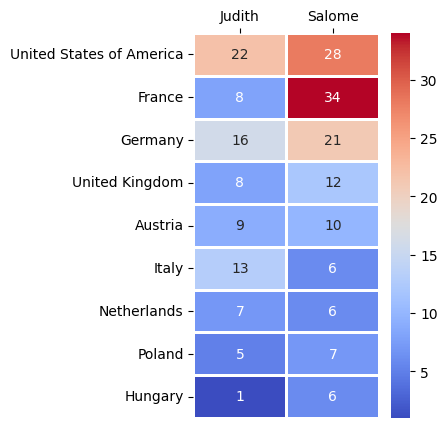

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3, 5))
ax = sns.heatmap(df, annot=True, linewidth=1, cmap='coolwarm');
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.savefig('out.png', bbox_inches='tight')